## Adversarial examples

In [ ]:
import PIL.Image as Image
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from torchvision.models.inception import inception_v3
model = inception_v3(pretrained=True,      # load existing weights
                     transform_input=True, # preprocess input image the same way as in training
                    )

model.aux_logits = False # don't predict intermediate logits (yellow layers at the bottom)
model.train(False)


In [ ]:
from torchvision import transforms
preprocess = transforms.Compose([
#    transforms.Resize((299, 299)),  # do we really need this now?
    transforms.ToTensor()#,
    ])

In [ ]:

!mkdir sample_images
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/sem4_spring19/week04_finetuning/sample_images/albatross.jpg -O sample_images/albatross.jpg

--2022-04-12 08:07:35--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/sem4_spring19/week04_finetuning/sample_images/albatross.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11607 (11K) [image/jpeg]
Saving to: ‘sample_images/albatross.jpg’

sample_images/albat 100%[===================>]  11.33K  --.-KB/s    in 0s      

2022-04-12 08:07:35 (103 MB/s) - ‘sample_images/albatross.jpg’ saved [11607/11607]



In [ ]:
import requests
# class labels
LABELS_URL = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'
labels = {int(key):value for (key, value) in requests.get(LABELS_URL).json().items()}


(299, 299, 3)


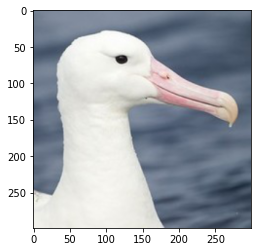

top-10 classes are: 
 [prob : class label]
[146 877 230 355 231  97   4 680 732]
0.9745 :	albatross
0.0030 :	turnstile
0.0005 :	Shetland_sheepdog
0.0005 :	llama
0.0003 :	collie
0.0003 :	drake
0.0003 :	hammerhead
0.0003 :	nipple
0.0003 :	Polaroid_camera


In [ ]:
from skimage.transform import resize
%matplotlib inline

img = resize(plt.imread('sample_images/albatross.jpg'), (299, 299))
print (img.shape)
plt.imshow(img)
plt.show()


def transform_input(img):
    return torch.as_tensor(img.reshape([1, 299, 299, 3]).transpose([0, 3, 1, 2]), dtype=torch.float32)


@torch.no_grad()
def predict(img, return_prob=False):
    img = transform_input(img)
    out = model(img)
    probs = torch.nn.functional.softmax(out, dim=-1)
    probs = probs.cpu().numpy()
    top_ix = probs.ravel().argsort()[-1:-10:-1]
    print ('top-10 classes are: \n [prob : class label]')
    print (top_ix)
    for l in top_ix:
        print ('%.4f :\t%s' % (probs.ravel()[l], labels[l][1]))
    if return_prob:
        return probs


probs = predict(img, True)


In [ ]:
modulelist = list(model.children())
print(len(modulelist))

def attack_image_fgsm(image, label, iterations, lr):
    input_var = torch.tensor(preprocess(image).unsqueeze(0), requires_grad=True,
                             dtype=torch.float32)
    
    model.zero_grad()
    loss = torch.nn.CrossEntropyLoss()

    out = model(input_var)
    cost_res = loss(out, label)
    if input_var.grad is not None:
        input_var.grad.data.fill_(0)
    cost_res.backward()

    # attack
    input_var_res = input_var + lr * input_var.grad.sign()

    input_im = input_var_res.data.squeeze(0).cpu()
    input_im.transpose_(0, 1)
    input_im.transpose_(1, 2)
    input_im = np.clip(input_im, 0, 1)
    im = Image.fromarray(np.uint8(input_im * 255))
    return im

def attack_image(image, layer_num, iterations, lr):
    input_var = torch.tensor(preprocess(image).unsqueeze(0), requires_grad=True,
                             dtype=torch.float32)
    model.zero_grad()
    for i in range(iterations):
        out = input_var
        for j in range(layer_num):
            out = modulelist[j](out)

        loss = out.norm()
        loss.backward()
        input_var.data = input_var.data + input_var.grad


    input_im = input_var.data.squeeze(0).cpu()
    input_im.transpose_(0, 1)
    input_im.transpose_(1, 2)
    input_im = np.clip(input_im, 0, 1)
    im = Image.fromarray(np.uint8(input_im * 255))
    return im

22


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


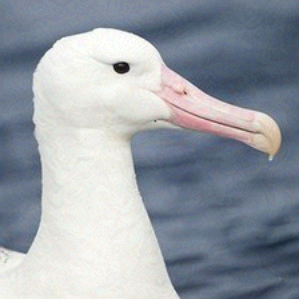

In [ ]:
#img = Image.fromarray(plt.imread('img.jpg'))
# img_adv = attack_image(img, 1, 2, 0.01 )   # YOUR CODE
img_adv = attack_image_fgsm(img, torch.tensor([10]), 2, 0.012 )   # YOUR CODE

img_adv

In [ ]:
predict(np.asarray(img_adv))

top-10 classes are: 
 [prob : class label]
[916 502 447 725 799 516 982 836 614]
0.9671 :	web_site
0.0229 :	clog
0.0086 :	binoculars
0.0009 :	pitcher
0.0002 :	sliding_door
0.0001 :	cradle
0.0001 :	groom
0.0000 :	sunglass
0.0000 :	kimono


In [ ]:
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/sem4_spring19/week04_finetuning/sample_images/kitty.jpg -O sample_images/hen.jpg

--2022-04-12 08:34:29--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/sem4_spring19/week04_finetuning/sample_images/kitty.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2022-04-12 08:34:29 ERROR 404: Not Found.



(299, 299, 3)


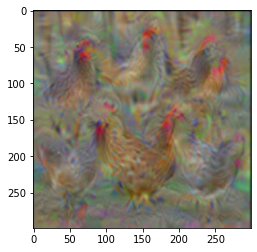

top-10 classes are: 
 [prob : class label]
[591 434 700 549 431 446 619 443 669]
0.1151 :	handkerchief
0.0882 :	bath_towel
0.0704 :	paper_towel
0.0691 :	envelope
0.0222 :	bassinet
0.0200 :	binder
0.0190 :	lampshade
0.0159 :	bib
0.0157 :	mosquito_net


In [ ]:
img1 = resize(plt.imread('sample_images/hen.jpg'), (299, 299))
print (img1.shape)
plt.imshow(img1)
plt.show()
predict(img1)
#img_adv = dd_helper_modified(img, 4, 5, 0.5)   # YOUR CODE
#img_adv

In [ ]:
predict(np.array(img_adv))

## Deep Network Visulization

<img src="https://raw.githubusercontent.com/slundberg/shap/master/docs/artwork/shap_header.svg" />

**SHAP (SHapley Additive exPlanations)** is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions (see papers for details and citations).



Imagine that the prediction is a result of a team game and we need to understand, how each player in your team influenced to the result.

The contribution of each feature is measured by the so-called **Shapley value** - a concept from **cooperative game theory** describing the contribution of the feature to prediction.

Lets see on the following example:

For example, you rent a one-bedroom apartment in Moscow and want to create a model that will predict the cost of the option you have chosen. For a given apartment, the model predicted a price of 1k $. Properties of the apartment for which the price was predicted: within the TTC, there is air conditioning, it is impossible to have pet, there is a park nearby. It is necessary to find **Shapley value** properties "it is impossible with pets", despite the fact that the average price of renting a one-bedroom is 1.100.


**Shapley value** is the average of possible **marginal contributions**. We create all possible sets over a set of properties, excluding the ones of interest ("it is impossible with pets"):

* no properties
* within the TTK
* conditioner
* near the park
* within the TTK, conditioner
* within the TTK, near the park
* conditioner, near the park
* within the TTK, near the park, conditioner


**Marginal contribution** = *model_predict*( inside ТТК & near park & without pets) -  *model_predict*(inside ТТК & near park)

**$$\text{Shapley value} =\frac{1}{S}\sum_{S}(\text{Marginal contribution})$$**
S - множество всех возможных наборов фичей


A prediction can be explained by assuming that each feature value of the instance is a “player” in a game where the prediction is the payout. Shapley values – a method from coalitional game theory – tells us how to fairly distribute the “payout” among the features.

In [ ]:
! pip3 install shap

     |████████████████████████████████| 564 kB 18.6 MB/s 


In [ ]:
import torch, torchvision
from torch import nn
from torchvision import transforms, models, datasets
import shap
import json
import numpy as np

# Explain an Intermediate Layers of Resnet50 on ImageNet

We use GradientExplainer model, which use expected gradients extention to estimate model's part input. In short, thay approximate SHAP values.

Explaining a prediction in terms of the original input image is harder than explaining the predicition in terms of a higher convolutional layer (because the higher convolutional layer is closer to the output). This notebook gives a simple example of how to use GradientExplainer to do explain a model output with respect to the convolution module from 2nd and 4th layers of the pretrained Resnet50 network.

Note that by default 200 samples are taken to compute the expectation. To run faster you can lower the number of samples per explanation.

Each layer in deep CNN learns filters of increasing complexity. The first layers learn basic feature detection filters such as edges and corners. The middle layers learn filters that detect parts of objects — for faces, they might learn to respond to eyes and noses. The last layers have higher representations: they learn to recognize full objects, in different shapes and positions.
Let explain features from the second block of ResNet: "fine" features


In [ ]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def normalize(image):
    if image.max() > 1:
        image /= 255
    image = (image - mean) / std
    # in addition, roll the axis so that they suit pytorch
    return torch.tensor(image.swapaxes(-1, 1).swapaxes(2, 3)).float()

Load proper model (**resnet50**) and data (**imagenet50**) from Shap wrapper

In [ ]:
model = models.resnet50(pretrained=True).eval()

X,y = shap.datasets.imagenet50()

X /= 255

to_explain = X[[1, 41]]
# Check 23, 30

# load the ImageNet class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)

with open(fname) as f:
    class_names = json.load(f)



Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

## Layer 1

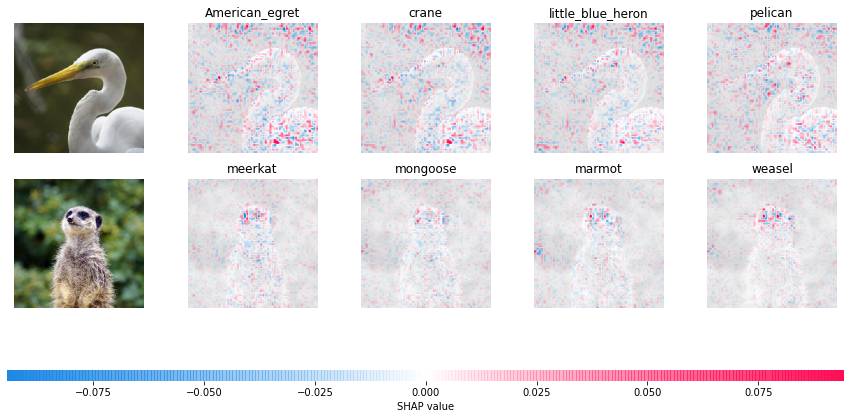

In [ ]:
 # create GradientExplainer object for convolution layer from Resnet Layer1
e = shap.GradientExplainer((model, model.layer1[0].conv2), normalize(X), label_smoothing=0.5)
shap_values,indexes = e.shap_values(normalize(to_explain), ranked_outputs=4, nsamples=70)
 # recieve shap_values


# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# plot the explanations
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]

shap.image_plot(shap_values, to_explain, index_names)

## Layer 2

In [ ]:
e = # create GradientExplainer object for convolution layer from Resnet Layer2
shap_values,indexes = # recieve shap_values

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)
    
# plot the explanations
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]

shap.image_plot(shap_values, to_explain, index_names)

## Layer 4

In [ ]:
e = # create GradientExplainer object for convolution layer from Resnet Layer4
shap_values,indexes = # recieve shap_values


# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

qu


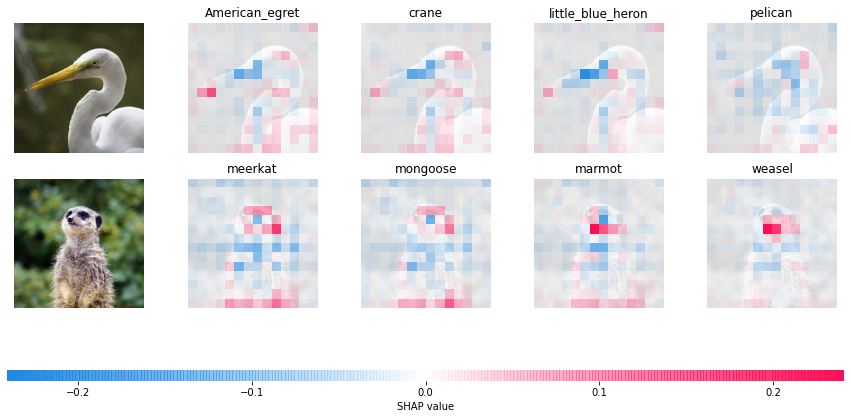

In [ ]:
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]

shap.image_plot(shap_values, to_explain, index_names)

## Explain with local smoothing

Gradient explainer uses expected gradients, which merges ideas from integrated gradients, SHAP, and SmoothGrad into a single expection equation. To use smoothing like SmoothGrad just set the local_smoothing parameter to something non-zero. This will add normally distributed noise with that standard deviation to the input during the expectation calculation. It can create smoother feature attributions that better capture correlated regions of the image.

## Layer 2

In [ ]:
# note that because the inputs are scaled to be between 0 and 1, the local smoothing also has to be
# scaled compared to the Keras model
e = # create GradientExplainer object for convolution layer from Resnet Layer2 with local smoothing
shap_values,indexes = # recieve shap_values

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# plot the explanations
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]

shap.image_plot(shap_values, to_explain, index_names)

## Layer 4

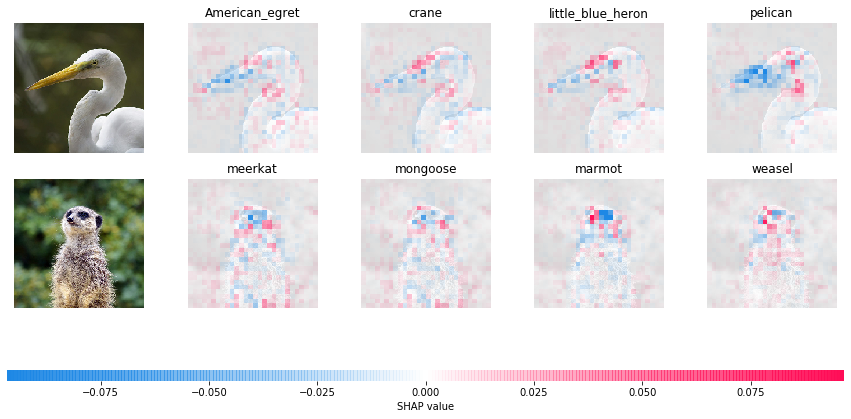

In [ ]:
# note that because the inputs are scaled to be between 0 and 1, the local smoothing also has to be
# scaled compared to the Keras model
e = # create GradientExplainer object for convolution layer from Resnet Layer4 with local smoothing
shap_values,indexes = # recieve shap_values


# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# plot the explanations
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]

shap.image_plot(shap_values, to_explain, index_names)